- Dimensiones de la imagen:
(1024, 1024, 3)


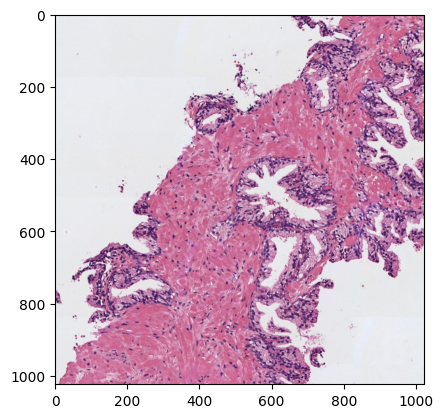

In [ ]:
# Utilizamos la librería skimage.io para leer la imagen 'histo_x.jpg' y visualízala usando la librería de matplotlib.
# Importante normalizar la imagen dividiéndola entre 255

import numpy as np

import matplotlib.pyplot as plt

from skimage import io

image=io.imread("rsc/histo_1.jpeg")/255.0    

print("- Dimensiones de la imagen:")

print(image.shape)

plt.imshow(image,vmin=0,vmax=1)

#### Realizar una transformación de color para convertir la imagen al espacio de color CMYK

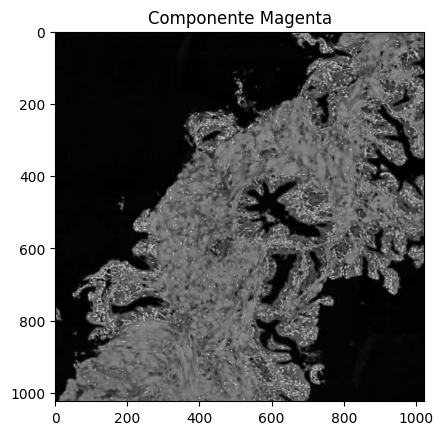

True

In [ ]:
# 1) Extraemos la componente magenta de la imagen (que corresponde a la región tisular)
# 2) Visualizamos la imagen con la librería de matplotlib. 
# 3) Guardamos la imagen Magenta con cv2.imwrite con el nombre "1_imagen_magenta.png"

import cv2

rgb = cv2.imread('rsc/histo_1.jpeg').astype('uint8')

# Extracción de los canales C, M, Y y K

with np.errstate(invalid='ignore', divide='ignore'):
    K = 255 - np.max(rgb, axis=2)
    C = (255 - rgb[...,2] - K) / (255 - K)  
    M = (255 - rgb[...,1] - K) / (255 - K)  
    Y = (255 - rgb[...,0] - K) / (255 - K)  

# Apilamos canales CMYK y dividir

CMYK = np.dstack((C, M, Y, K))

C, M, Y, K = cv2.split(CMYK)

# Visualizamos imagen magenta

fig, ax = plt.subplots(1, 1)

ax.imshow(M, cmap='gray')  

ax.set_title('Componente Magenta')

plt.show()

# Guardamos la imagen en escala de 0-255

M_uint8 = (M * 255).astype('uint8')

cv2.imwrite('img/1_imagen_magenta.png', M_uint8)

#### Umbralizar la imagen para separar los píxeles del fondo de la región tisular

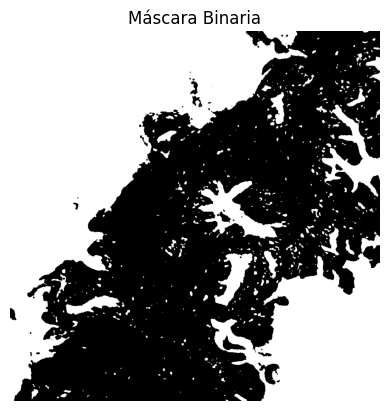

True

In [ ]:
# 1) Convertimos la imagen Magenta a formato "uint8"
# 2) Aplicamos un filtro gaussiano de tamaño 5x5
# 3) Umbralizamos la imagen aplicando el método de Otsu
# 4) Aplicamos el umbral de manera que los píxeles del fondo y de los lúmenes sean 1s y el resto 0s. 
# 5) Visualizamos la máscara resultante (imagen de 0s y 1s)
# 6) Guardamos la máscara multiplicándola por 255 con el nombre "2_mascara_con_artefactos.png"

# Cargamos la imagen Magenta
imagen_magenta = cv2.imread("img/1_imagen_magenta.png", cv2.IMREAD_GRAYSCALE)

# 1) Convertimos a uint8
imagen_magenta_uint8 = imagen_magenta.astype(np.uint8)

# 2) Aplicamos un filtro gaussiano de tamaño 5x5
imagen_filtrada = cv2.GaussianBlur(imagen_magenta_uint8, (5, 5), 0)

# 3) Umbralizamos la imagen usando el método de Otsu
_, imagen_umbralizada = cv2.threshold(imagen_filtrada, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 4) Invertimos la imagen para que fondo y lúmenes sean 1s y el resto 0s

mascara_binaria = (imagen_umbralizada == 0).astype(np.uint8)

# 5) Visualizamos la máscara resultante

plt.imshow(mascara_binaria, cmap='gray')

plt.title("Máscara Binaria")

plt.axis("off")

plt.show()

# 6) Guardamos la máscara multiplicándola por 255

cv2.imwrite("img/2_mascara_con_artefactos.png", mascara_binaria * 255)


#### Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)

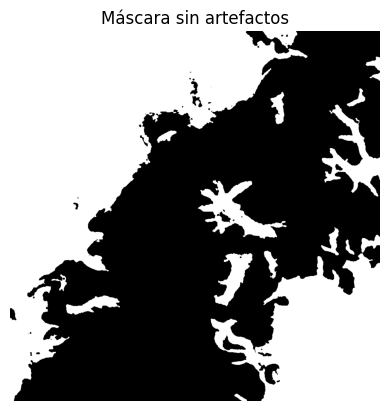

True

In [ ]:
# 1) Utilizando la librería skimage.morphology.remove_small_objects. 
# Documentación en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Fijamos el umbral en 300 píxeles y la conectividad del objeto en 8 píxeles.
# 2) Convertimos la máscara generada en formato uint8
# 3) Visualizamos la máscara resultante
# 4) Guardamos la máscara multiplicándola por 255 con el nombre "3_mascara_sin_artefactos.png"

from skimage.morphology import remove_small_objects

# Cargamos la máscara
mascara = cv2.imread("img/2_mascara_con_artefactos.png", cv2.IMREAD_GRAYSCALE)

# Convertimos a valores binarios (0 y 1)
mascara_binaria = (mascara > 0).astype(bool)

# 1) Eliminamos pequeños objetos con umbral de 300 píxeles y conectividad 8
mascara_limpia = remove_small_objects(mascara_binaria, min_size=300, connectivity=8)

# 2) Convertimos la máscara a uint8
mascara_uint8 = (mascara_limpia * 255).astype(np.uint8)

# 3) Visualizamos la máscara resultante
plt.imshow(mascara_uint8, cmap="gray")

plt.title("Máscara sin artefactos")

plt.axis("off")

plt.show()

# 4) Guardamos la máscara resultante
cv2.imwrite("img/3_mascara_sin_artefactos.png", mascara_uint8)

#### Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

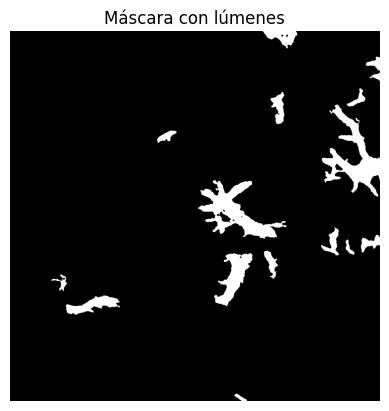

True

In [ ]:
# 1) Aplicmos el algoritmo de expansión a partir de semillas para rellenar con 0s
# Pon dos semillas: una en la esquina superior izquierda y otra en la esquina inferior derecha.
# 2) Visualizamos la máscara resultante
# 3) Guardamos la máscara multiplicándola por 255 con el nombre "4_mascara_lumenes.png"

from skimage.morphology import flood_fill

# Cargamos la máscara anterior
mascara = cv2.imread("img/3_mascara_sin_artefactos.png", cv2.IMREAD_GRAYSCALE)

# Para asegurarnos de que los valores sean binarios (0 y 1)
mascara_binaria = (mascara > 0).astype(np.uint8)

# 1) Aplicar algoritmo de expansión de semillas
mascara_rellena = mascara_binaria.copy()

# Semillas en las esquinas
seed1 = (0, 0) 
seed2 = (mascara.shape[0] - 1, mascara.shape[1] - 1)  

# Rellenamos con 0s desde las semillas
mascara_rellena = flood_fill(mascara_rellena, seed1, 0)

mascara_rellena = flood_fill(mascara_rellena, seed2, 0)

# 2) Visualizamos la máscara resultante
plt.imshow(mascara_rellena, cmap="gray")

plt.title("Máscara con lúmenes")

plt.axis("off")

plt.show()

# 3) Guardamos la máscara multiplicándola por 255
mascara_uint8 = (mascara_rellena * 255).astype(np.uint8)

cv2.imwrite("img/4_mascara_lumenes.png", mascara_uint8)

#### Rellenar los objetos de los lúmenes

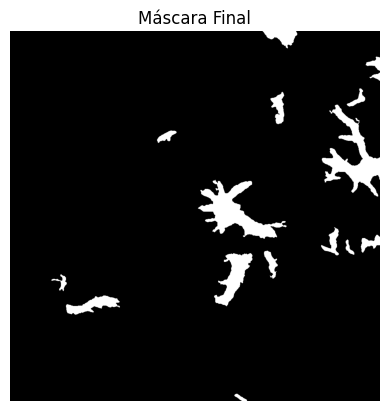

True

In [ ]:
# 1) Rellenamos los lúmenes con la función binary_fill_holes de la librería scipy.ndimage.morphology
# 2) Convertimos la máscara resultante en formato uint8
# 3) Visualizamos la máscara
# 4) Guardamos la máscara multiplicándola por 255 con el nombre "5_mascara_final.png"

from scipy.ndimage import binary_fill_holes

# 1) Cargamos la máscara anterior
mascara = cv2.imread("img/4_mascara_lumenes.png", cv2.IMREAD_GRAYSCALE)

# Nos aseguramos de que los valores sean binarios (0 y 1)
mascara_binaria = (mascara > 0).astype(np.uint8)

# Rellenamos los lúmenes
mascara_rellena = binary_fill_holes(mascara_binaria).astype(np.uint8)

# 2) Convertimos a formato uint8
mascara_uint8 = (mascara_rellena * 255).astype(np.uint8)

# 3) Visualizamos la máscara
plt.imshow(mascara_uint8, cmap="gray")

plt.title("Máscara Final")

plt.axis("off")

plt.show()

# 4) Guardamos la máscara final
cv2.imwrite("img/5_mascara_final.png", mascara_uint8)

#### Detectar y dibujar los contornos de los lúmenes sobre la imagen original

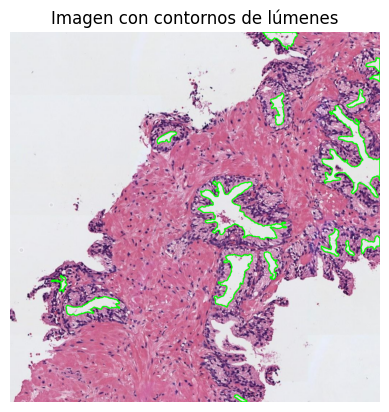

True

In [ ]:
# 1) Encontraremos los contornos de los lúmenes
# 2) Dibujaremos los contornos (de color verde) sobre la imagen original
# 3) Visualización de la imagen superpuesta
# 4) Guardamos la imagen multiplicándola por 255 con el nombre "6_imagen_superpuesta.png"
# 1) Cargamos la máscara final y la imagen original

mascara = cv2.imread("img/5_mascara_final.png", cv2.IMREAD_GRAYSCALE)

imagen_original = cv2.imread("histo_1.jpeg")  # Asegúrate de usar la imagen correcta

# 2) Encontrar los contornos de los lúmenes
contornos, _ = cv2.findContours(mascara, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3) Dibujamos los contornos en la imagen original (color verde BGR: (0,255,0))
imagen_con_contornos = imagen_original.copy()

cv2.drawContours(imagen_con_contornos, contornos, -1, (0, 255, 0), 2)

# 4) Visualizar la imagen resultante
plt.imshow(cv2.cvtColor(imagen_con_contornos, cv2.COLOR_BGR2RGB))

plt.title("Imagen con contornos de lúmenes")

plt.axis("off")

plt.show()

# 5) Guardamos la imagen resultante
cv2.imwrite("img/6_imagen_superpuesta.png", imagen_con_contornos)

#### Identificar y cropear el lumen más grande

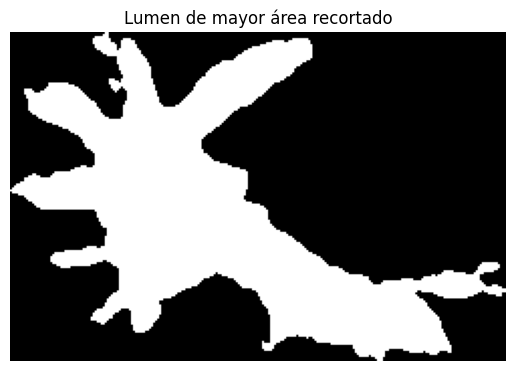

True

In [ ]:
# 1) Convertimos la máscara de lúmenes en una imagen de etiquetas utilizando la librería skimage.measure
# 2) Calculamos el área de cada uno de los lúmenes 
# 3) Obtenemos una máscara del lumen de mayor área
# 4) Recortamos el lumen de mayor área utilizando las coordenadas de la bounding box
# 5) Visualizamos la máscara recortada del lumen
# 6) Guardamos la imagen multiplicándola por 255 con el nombre "7_crop_image.png"

from skimage.measure import label, regionprops

# 1) Cargamos la máscara de lúmenes
mascara = cv2.imread("img/5_mascara_final.png", cv2.IMREAD_GRAYSCALE)

# 2) Convertimos la máscara en una imagen de etiquetas
etiquetas = label(mascara)

# 3) Calculamos el área de cada lumen y obtener el de mayor área
props = regionprops(etiquetas)

max_region = max(props, key=lambda x: x.area)

# 4) Obtenemos la máscara del lumen de mayor área
mascara_lumen_mayor = np.zeros_like(mascara)

mascara_lumen_mayor[etiquetas == max_region.label] = 255

# Obtener las coordenadas de la bounding box (xmin, ymin, xmax, ymax)
minr, minc, maxr, maxc = max_region.bbox

# Recortar la imagen con la bounding box
crop_image = mascara_lumen_mayor[minr:maxr, minc:maxc]

# 5) Visualizar la máscara recortada del lumen
plt.imshow(crop_image, cmap="gray")

plt.title("Lumen de mayor área recortado")

plt.axis("off")

plt.show()

# 6) Guardar la imagen multiplicándola por 255
cv2.imwrite("img/7_crop_image.png", crop_image)

#### Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

In [ ]:
# Calcula las siguientes características del crop del lumen anterior, redondeando su valor hasta el cuarto decimal.
# 1) Área
# 2) Área de la bounding box
# 3) Área convexa
# 4) Exentricidad
# 5) Diámetro equivalente
# 6) Extensión
# 7) Longitud del eje mayor
# 8) Longitud del eje menor
# 9) Orientación
# 10) Perímetro
# 11) Solidez
# 12) Compacidad
# 13) Rectangularidad

from skimage.measure import regionprops

# 1) Cargamos la imagen recortada del lumen

crop_image = cv2.imread("img/7_crop_image.png", cv2.IMREAD_GRAYSCALE)

# 2) Etiquetamos la imagen

etiquetas = crop_image > 0

props = regionprops(etiquetas.astype(int))[0] 

# 3) Calculamos las características y redondearlas a 4 decimales

features = {
    'Área': round(max_region.area, 4),
    'Área Bounding Box': round((maxr - minr) * (maxc - minc), 4),
    'Área Convexa': round(max_region.convex_area, 4),
    'Excentricidad': round(max_region.eccentricity, 4),
    'Diámetro Equivalente': round(max_region.equivalent_diameter, 4),
    'Extensión': round(max_region.extent, 4),
    'Longitud del Eje Mayor': round(max_region.major_axis_length, 4),
    'Longitud del Eje Menor': round(max_region.minor_axis_length, 4),
    'Orientación': round(max_region.orientation, 4),
    'Perímetro': round(max_region.perimeter, 4),
    'Solidez': round(max_region.solidity, 4),
    'Compacidad': round((max_region.perimeter ** 2) / max_region.area, 4),
    'Rectangularidad': round(max_region.area / ((maxr - minr) * (maxc - minc)), 4)
}

# 4) Imprimimos las características

for clave, valor in features.items():
    print(f"{clave}: {valor}")

Área: 14108.0
Área Bounding Box: 40098
Área Convexa: 29267.0
Excentricidad: 0.8469
Diámetro Equivalente: 134.0256
Extensión: 0.3518
Longitud del Eje Mayor: 238.4593
Longitud del Eje Menor: 126.7907
Orientación: 1.0049
Perímetro: 1239.1474
Solidez: 0.482
Compacidad: 108.838
Rectangularidad: 0.3518


En el PDF adjunto en el directorio del protecto podemos ver las conclusiones después de haber realizado este proceso en ambas imagenes de las células.